# Unsupervised Learning Approach to Unveil Latent Consumers in Permanent Makeup Market

The permanent makeup market (PMU) has been experiencing steady growth over the years and is projected to continue expanding in the beauty industry. The application of cosmetic tattoos does not only offer convenience, but also helps to camouflage scars, acne, hyperpigmentation, and others. One of the challenges that PMU market faces is that it often focuses on traditional cosmetic consumers who are influencer-aligned and driven by du jour beauty trends.

This project's goal is to simulate and unveil non-obvious potential target groups for PMU. Unlike other makeup products, consumers may be hesitant towards it due to the financial cost, pain, socio-cultural stigma, permanence, or skepticism. This project aims to identify these high-curiosity low-action people who represent latent demand. Using unsupervised learning and synthetic data, the project will explore the traits of potential consumers by analyzing their personalities, risk aversion, values, and influencer trust that goes beyond demographics.

Unsupervised Learning Approaches
For this project, we'll use methods such as K-Means clustering to partition the data into k=2 groups based on feature similarity. HDBSCAN will be used for organic segmentation and UMAP will be used to reduce dimensionality while preserving the local structure. Through cluster profiling, interpretation of different consumer psychology will be created. Intervention simulation will be used to see how changes in feature distributions affect the cluster composition without supervision. 

The final result will be profiles of latent consumers of PMU. 

Project Breakdown:
* Synthetic Data 
* Data Preprocessing
* Clustering Evaluation
* Simulate Messaging Reactions
* Simulate Interventions
* Consumer Profiles

## Synthetic Data
Generate synthetic data that will help the clustering model different consumer archetypes that includes demographic, psychological, behavioral, cultural and motivational factors that may play role in their interest in PMU

Feature Groups
* Demographics
    * age: Ranging from 18-65, int
    * income: Annual using log-normal distribution, float
    * location_type: urban, suburban, rural. Affects channel preference
    * education_level: HS, college, grad, other
* Psychographics (all float, ranging from 0-1)
    * self_image_dependence: High value means influenced greatly by self-image
    * risk_tolerance: High value indicates more comfortable with procedure
    * novelty_seeking: High value shows more open to trying PMU
    * beauty_confidence: Low value indicates more likely to seek cosmetic enhancement
    * pain_sensitivity: High value shows more aversion towards needles or pain in general
* Beliefs (all float, ranging from 0-1) 
    * tattoo_acceptance: High value shows more comfort towards tattoo
    * cultural_conservatism: High value indicates more hesitancy 
    * natural_look_preference: High value indicates more likely to try PMU for natural looks
* Behavior 
    * minutes_on_makeup_per_day: Lower value shows higher PMU convenience appeal, minutes int
    * skincare_loyatly_score: Proxy for interest in beauty investment, float
    * prior_pmu_experience: Binary 0/1. Those with prior may be more open
    * pmu_interest_level: Used only for interpretation and not clustering, float
* Social Influence 
    * influencer_trust: Affects how much decision is tied to influencer marketing, float
    * preferred_discovery_channel: IG, referral, in-store, YT
    * information_skepticism: High value shows more challenge to convert with just marketing, float 

In [1]:
import hdbscan
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from IPython.display import display
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [2]:
def generate_synthetic_pmu_consumers(n=1000, seed=42):
    np.random.seed(seed)

    age = np.clip(np.random.normal(35, 10, n), 18, 65).astype(int)
    income = np.clip(np.random.normal(50000, 15000, n), 20000, 150000)
    location_type = np.random.choice(["urban", "suburban", "rural"], size=n, p=[0.5, 0.3, 0.2])
    education_level = np.random.choice(["high_school", "college", "graduate", "other"], size=n, p=[0.2, 0.5, 0.25, 0.05])

    self_image_dependence = np.random.beta(2, 2, n)
    risk_tolerance = np.random.beta(2, 5, n)
    novelty_seeking = np.random.beta(3, 2, n)
    beauty_confidence = np.random.beta(2, 2, n)
    pain_sensitivity = np.random.beta(5, 2, n)

    tattoo_acceptance = np.random.beta(2, 3, n)
    cultural_conservatism = np.random.beta(2, 3, n)
    natural_look_preference = np.random.beta(3, 2, n)

    minutes_on_makeup_per_day = np.clip(np.random.normal(30, 15, n), 0, 90)
    skincare_loyalty_score = np.random.beta(2, 2, n)
    prior_pmu_experience = np.random.choice([0, 1], size=n, p=[0.8, 0.2])

    influencer_trust = np.random.beta(2, 3, n)
    preferred_discovery_channel = np.random.choice(
        ["Instagram", "referral", "in-store", "YouTube"], size=n, p=[0.4, 0.3, 0.2, 0.1]
    )
    information_skepticism = np.random.beta(2, 3, n)

    interest_base = (
        0.5 * (1 - beauty_confidence) +
        0.3 * self_image_dependence +
        0.2 * novelty_seeking -
        0.3 * pain_sensitivity -
        0.2 * cultural_conservatism
    )

    pmu_interest_level = np.clip(interest_base + np.random.normal(0, 0.1, n), 0, 1)

    df = pd.DataFrame({
        "age": age,
        "income": income,
        "location_type": location_type,
        "education_level": education_level,
        "self_image_dependence": self_image_dependence,
        "risk_tolerance": risk_tolerance,
        "novelty_seeking": novelty_seeking,
        "beauty_confidence": beauty_confidence,
        "pain_sensitivity": pain_sensitivity,
        "tattoo_acceptance": tattoo_acceptance,
        "cultural_conservatism": cultural_conservatism,
        "natural_look_preference": natural_look_preference,
        "minutes_on_makeup_per_day": minutes_on_makeup_per_day,
        "skincare_loyalty_score": skincare_loyalty_score,
        "prior_pmu_experience": prior_pmu_experience,
        "influencer_trust": influencer_trust,
        "preferred_discovery_channel": preferred_discovery_channel,
        "information_skepticism": information_skepticism,
        "pmu_interest_level": pmu_interest_level,
    })

    return df

if __name__ == "__main__":
    df = generate_synthetic_pmu_consumers(n=1000)
    df.to_csv("data/synthetic_pmu_consumers.csv", index=False)
    print("Synthetic dataset saved as 'synthetic_pmu_consumers.csv in your data folder'")

df.head()

Synthetic dataset saved as 'synthetic_pmu_consumers.csv in your data folder'


,age,income,location_type,education_level,self_image_dependence,risk_tolerance,novelty_seeking,beauty_confidence,pain_sensitivity,tattoo_acceptance,cultural_conservatism,natural_look_preference,minutes_on_makeup_per_day,skincare_loyalty_score,prior_pmu_experience,influencer_trust,preferred_discovery_channel,information_skepticism,pmu_interest_level
0,39,70990.331549,urban,college,0.573463,0.231549,0.471376,0.408567,0.705472,0.486574,0.084764,0.539120,23.366432,0.206355,1,0.375321,in-store,0.100943,0.485899
1,33,63869.505244,urban,college,0.945007,0.237869,0.554801,0.432963,0.527976,0.593157,0.294994,0.858432,37.958793,0.713261,0,0.618419,referral,0.724557,0.337801
2,41,50894.455549,urban,graduate,0.173391,0.204004,0.567151,0.785188,0.704442,0.190568,0.447128,0.766878,7.855831,0.054304,0,0.520627,Instagram,0.375203,0.000000
3,50,40295.948334,urban,high_school,0.606179,0.419159,0.793522,0.432443,0.876663,0.141062,0.314823,0.551428,23.155248,0.539246,0,0.103015,Instagram,0.362956,0.229952
4,32,60473.349704,rural,college,0.781396,0.187980,0.459770,0.340573,0.635332,0.222087,0.157498,0.440515,0.000000,0.420822,0,0.539433,YouTube,0.198484,0.443716


## Data Preprocessing
Data preparation for clustering and visualiztion
* Normalize numeric features using StandarScaler
* Use one-hot encode categorical features
* Dimensionality reduction using PCA and UMAP for better local structure
* Visualize

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


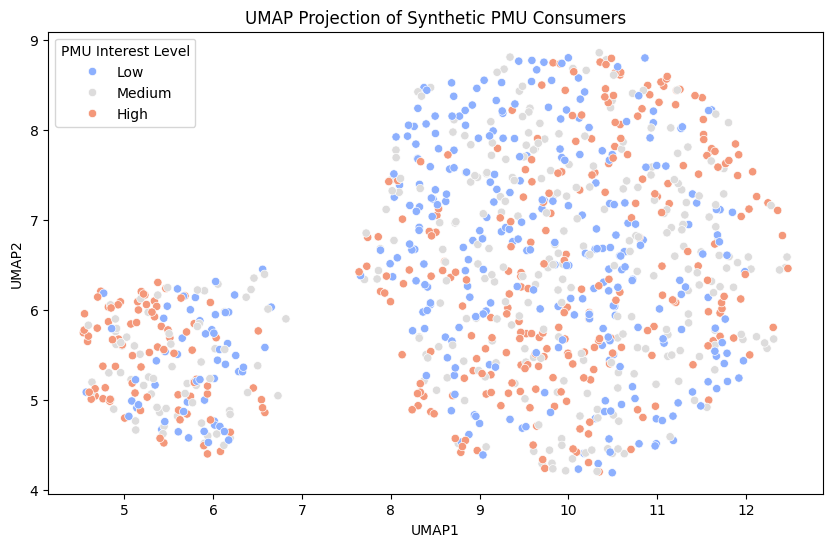

In [3]:
df = pd.read_csv("data/synthetic_pmu_consumers.csv")
categorical_features = ['location_type', 'education_level', 'preferred_discovery_channel']
numeric_features = [col for col in df.columns if col not in categorical_features + ['pmu_interest_level']]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(sparse=False), categorical_features)
])

X_preprocessed = preprocessor.fit_transform(df)

ohe = preprocessor.named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(encoded_cat_names)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_preprocessed)

reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_preprocessed)

df_plot = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
df_plot['Interest Level'] = pd.qcut(df['pmu_interest_level'], q=3, labels=["Low", "Medium", "High"])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x="UMAP1", y="UMAP2", hue="Interest Level", palette="coolwarm")
plt.title("UMAP Projection of Synthetic PMU Consumers")
plt.legend(title="PMU Interest Level")
plt.show()

Left
* Dense area, potential early adopters of PMU
* Highly confident, social, and self-image conscious
Right
* Diffused, potential mixed market
* Includes minimalists, skeptics, and curious yet anxious crowd
Dispersed lows
* Spread across left and right clusters
* Low PMU interest

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.1

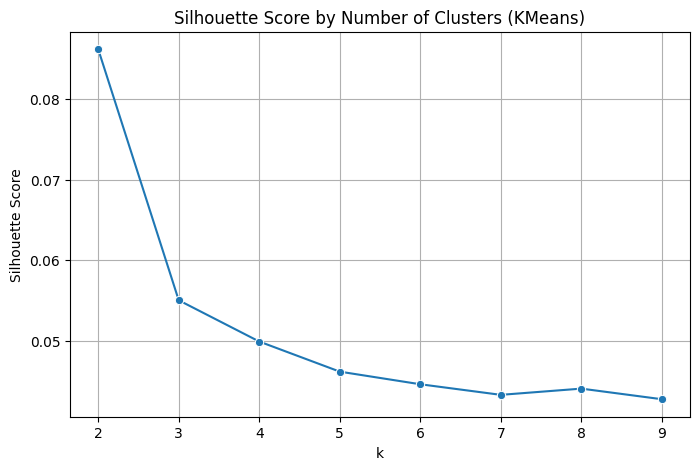

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


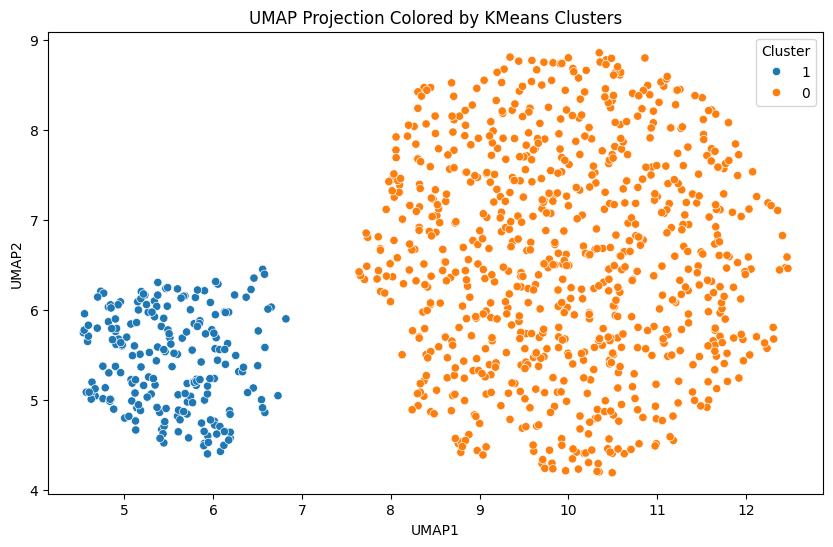

In [4]:
# Find silhouette score loop to find best K
silhouette_scores = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_preprocessed)
    silhouette_scores.append(silhouette_score(X_preprocessed, labels))

plt.figure(figsize=(8, 5))
sns.lineplot(x=k_values, y=silhouette_scores, marker='o')
plt.title("Silhouette Score by Number of Clusters (KMeans)")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(silhouette_scores)]
kmeans = KMeans(n_clusters=best_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_preprocessed)

reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_preprocessed)

df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
df_umap['Cluster'] = df['cluster'].astype(str)
df_umap['PMU Interest'] = pd.qcut(df['pmu_interest_level'], q=3, labels=['Low', 'Medium', 'High'])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='Cluster', palette='tab10')
plt.title("UMAP Projection Colored by KMeans Clusters")
plt.legend(title="Cluster")
plt.show()

df.to_csv("data/synthetic_pmu_with_clusters.csv", index=False)

Silhouette Score
* Peak at k=2 (approx 0.088 score), the optimal number of clusters
* Two clusters are the most naturally separated and compact in the synthetic data
    * Adding more clusters beyond 2 decreases the score 
 
Validate whether 2 clusters is the best choice with HDBSCAN

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


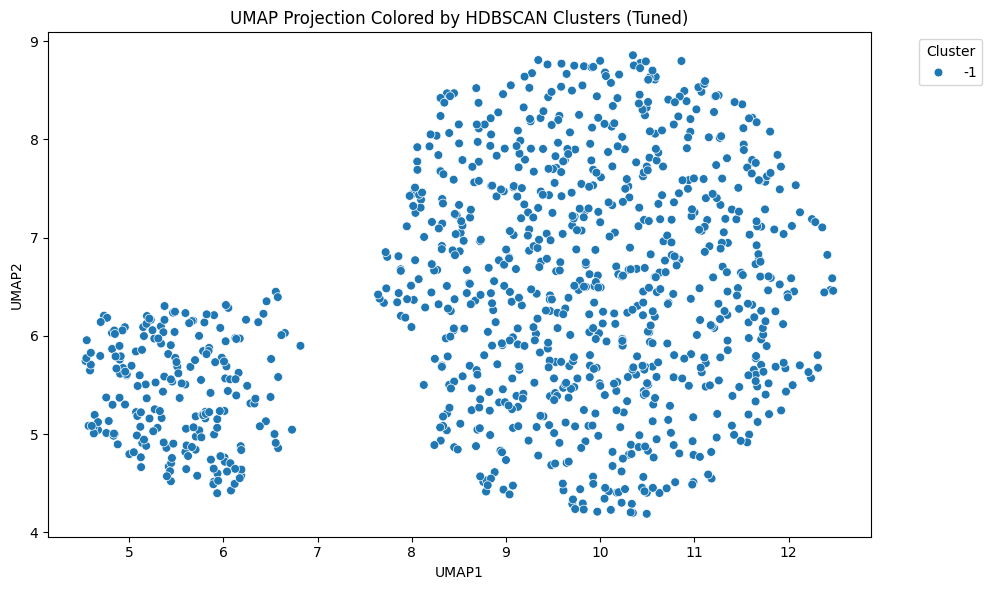

hdbscan_cluster
-1    1000
Name: count, dtype: int64


In [5]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5)
hdb_labels = clusterer.fit_predict(X_preprocessed)

df['hdbscan_cluster'] = hdb_labels

reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_preprocessed)

df_umap = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
df_umap["Cluster"] = df['hdbscan_cluster'].astype(str)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", hue="Cluster", palette="tab10", s=40)
plt.title("UMAP Projection Colored by HDBSCAN Clusters (Tuned)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
print(df['hdbscan_cluster'].value_counts().sort_index())

HDBSCAN
* Every point was labeled as noise (-1)
    * No clusters found despite loose parameters
* Synthetic data is evenly distributed (no dense clusters)
* UMAP clusters ≠ HDBSCAN clusters — visual separation ≠ density-based separability
* Silhouette score and UMAP plots confirm that K-Means is more appropriate

Use K-Means with k=2 as core unsupervised method

## Clustering Evaluation
Measure the following:
* Silhouette score - cluster compactness and separation
* Davies-Bouldin Index - intra-cluster similarity and inter-cluster differences

In [6]:
df = pd.read_csv("data/synthetic_pmu_with_clusters.csv")
categorical_features = ['location_type', 'education_level', 'preferred_discovery_channel']
numeric_features = [col for col in df.columns if col not in categorical_features + ['pmu_interest_level', 'cluster']]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(sparse=False), categorical_features)
])
X_preprocessed = preprocessor.fit_transform(df)

sil_score = silhouette_score(X_preprocessed, df['cluster'])
db_index = davies_bouldin_score(X_preprocessed, df['cluster'])

evaluation_df = pd.DataFrame({
    "Metric": ["Silhouette Score", "Davies-Bouldin Index"],
    "Value": [round(sil_score, 4), round(db_index, 4)]
})
evaluation_df

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Metric,Value
0,Silhouette Score,0.0862
1,Davies-Bouldin Index,3.1642


Silhouette Score
* Positive but low
* Clusters are not strong in structure, but they're somewhat disntic and have some overlap between them
* While there's not strong natural clustering structure, the subtle distinctions in the data still offer menaingful insights

Davies-Bouldin Index
* Score of 3.1642 shows:
    * Moderate internal spread
    * Overlap or proximity between clusters
* Suggests that the archetypes likey have subtle differences, but not drastic splits

Insights:
* Clusters are soft, but the visual separation in UMAP does show meaningful distinctions
* For simulation testing, explore the effects of small mindset shifts on PMU interest
* Focus on behavioral patterns rather than fixed types since these are soft personas

## Persona Visualization
* Show the profile of each consumer persona across the 12 features 
* Compare their PMU interest (pmu_interest_level) between clusters
* Highlight top distinguishing features
    * This will help to see which traits have the most influence in PMU receptibility 


Cluster Mean Trait Values:

         self_image_dependence  risk_tolerance  novelty_seeking  \
cluster                                                           
0                         0.51            0.28             0.60   
1                         0.52            0.28             0.63   

         beauty_confidence  pain_sensitivity  tattoo_acceptance  \
cluster                                                           
0                     0.51              0.72               0.41   
1                     0.52              0.71               0.41   

         cultural_conservatism  natural_look_preference  \
cluster                                                   
0                         0.41                     0.60   
1                         0.38                     0.61   

         minutes_on_makeup_per_day  skincare_loyalty_score  influencer_trust  \
cluster                                                                        
0                            31.00  

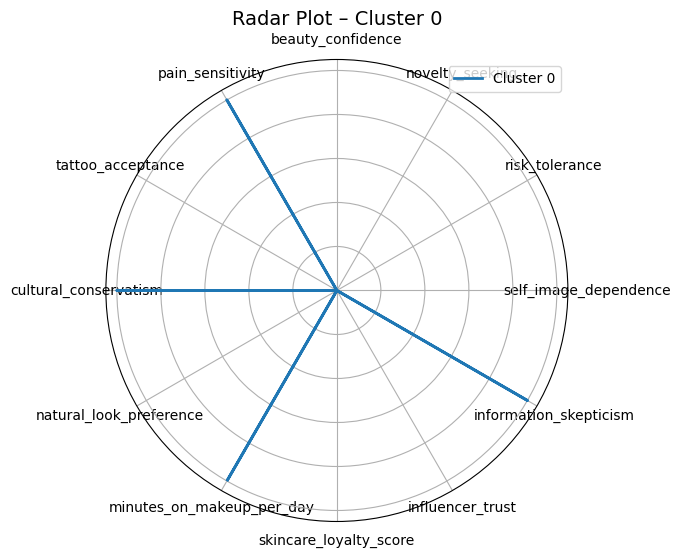


Raw Trait Values for Cluster 0:

self_image_dependence         0.51
risk_tolerance                0.28
novelty_seeking               0.60
beauty_confidence             0.51
pain_sensitivity              0.72
tattoo_acceptance             0.41
cultural_conservatism         0.41
natural_look_preference       0.60
minutes_on_makeup_per_day    31.00
skincare_loyalty_score        0.50
influencer_trust              0.39
information_skepticism        0.41
Name: 0, dtype: float64


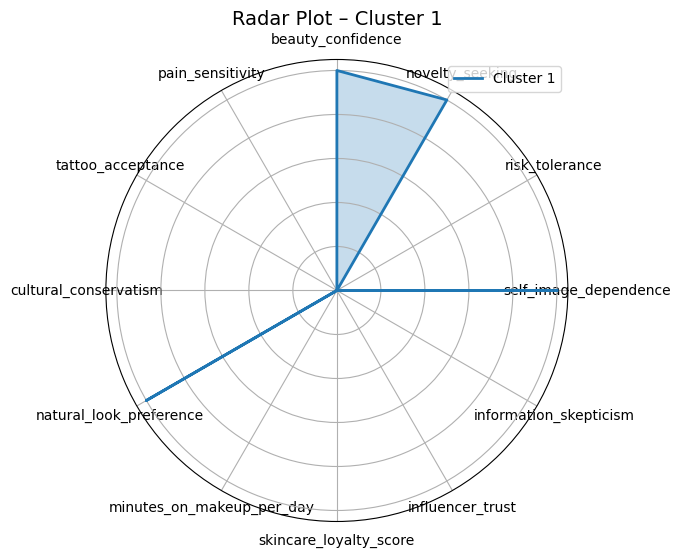


Raw Trait Values for Cluster 1:

self_image_dependence         0.52
risk_tolerance                0.28
novelty_seeking               0.63
beauty_confidence             0.52
pain_sensitivity              0.71
tattoo_acceptance             0.41
cultural_conservatism         0.38
natural_look_preference       0.61
minutes_on_makeup_per_day    30.09
skincare_loyalty_score        0.50
influencer_trust              0.39
information_skepticism        0.39
Name: 1, dtype: float64


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_4154/2761472371.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster', y='pmu_interest_level', palette='Set2')


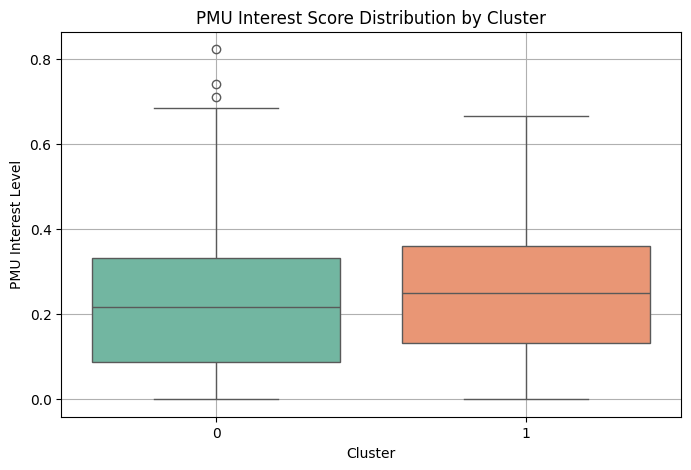


PMU Interest Summary by Cluster:

         count  mean   std  min   25%   50%   75%   max
cluster                                                
0        793.0  0.22  0.16  0.0  0.09  0.22  0.33  0.82
1        207.0  0.25  0.16  0.0  0.13  0.25  0.36  0.67


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_4154/2761472371.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=diffs.values, y=diffs.index, palette="viridis")


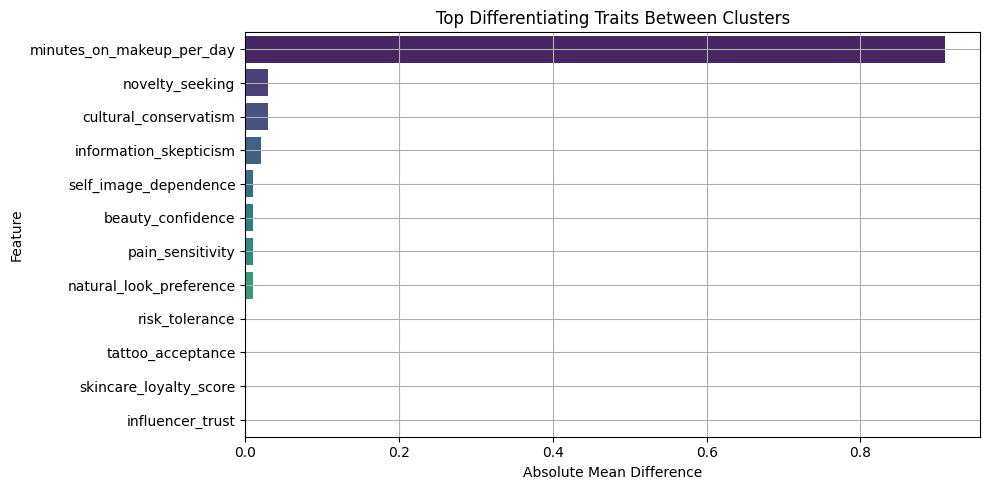


Top Differentiating Features:

minutes_on_makeup_per_day    0.91
novelty_seeking              0.03
cultural_conservatism        0.03
information_skepticism       0.02
self_image_dependence        0.01
beauty_confidence            0.01
pain_sensitivity             0.01
natural_look_preference      0.01
risk_tolerance               0.00
tattoo_acceptance            0.00
dtype: float64


In [7]:
core_features = [
    'self_image_dependence', 'risk_tolerance', 'novelty_seeking',
    'beauty_confidence', 'pain_sensitivity', 'tattoo_acceptance',
    'cultural_conservatism', 'natural_look_preference', 'minutes_on_makeup_per_day',
    'skincare_loyalty_score', 'influencer_trust', 'information_skepticism'
]

cluster_means = df.groupby('cluster')[core_features].mean().round(2)
print("\nCluster Mean Trait Values:\n")
print(cluster_means)

scaler = MinMaxScaler()
cluster_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_means),
    index=cluster_means.index,
    columns=cluster_means.columns
)

# Radar plot
labels = core_features
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

for cluster_id in cluster_scaled.index:
    values = cluster_scaled.loc[cluster_id].tolist()
    values += values[:1]
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, linewidth=2, label=f"Cluster {cluster_id}")
    ax.fill(angles, values, alpha=0.25)
    ax.set_title(f"Radar Plot – Cluster {cluster_id}", size=14)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_yticklabels([])
    ax.grid(True)
    plt.legend()
    plt.show()
    print(f"\nRaw Trait Values for Cluster {cluster_id}:\n")
    print(cluster_means.loc[cluster_id])

# PMU Interest Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='cluster', y='pmu_interest_level', palette='Set2')
plt.title("PMU Interest Score Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("PMU Interest Level")
plt.grid(True)
plt.show()
print("\nPMU Interest Summary by Cluster:\n")
print(df.groupby('cluster')['pmu_interest_level'].describe().round(2))

# Top differentiating traits
diffs = (cluster_means.loc[0] - cluster_means.loc[1]).abs().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=diffs.values, y=diffs.index, palette="viridis")
plt.title("Top Differentiating Traits Between Clusters")
plt.xlabel("Absolute Mean Difference")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()
print("\nTop Differentiating Features:\n")
print(diffs.head(10))

Cluster 0 - Cautious Consumer
* This is the cluster of consumers who are generally cautious and have high aversion to pain and change
* On average, they spend 31 minutes on appearance, have some curiosity about trends, but tend to avoid commitment to new beauty products or services if they do not feel safe
* Low PMU interest due to low risk tolerance and high pain sensitivity

Cluster 1 - Curious Consumer
* This is the cluster of consumers who are slightly more curious and open to try new beauty practices. They are less conservative
* PMU interest is still low, but noticeably higher than the Cautious Consumer group
* This is the group that could appreciate and potentially adopt PMU given more education, testimonials, and low-barrier experiences to explore

Top Differentiating Features
* minutes_on_makeup_per_day showed meaningful separation, showing a 1-min difference
    * Could be attributed to randomness
* The rest of the features showed minor shifts, showing that the consumer personas are not black-and-white
* Shows that the consumer personas are valid but only have subtle distinctions
    * Targetting them with different products don't work. They need education, distinct tones of messaging, and risk-reducing options to experiment

## Simulate Messaging Reactions
* See wich messaging strategies yield the best average simulated reaction scores from each group
* Strategies tested:
    * Educational
    * Exclusive offer
    * Influencer testinmonial
    * Emphasis on nautral beauty


Simulated Messaging Reactions by Consumer:

                   reaction_educational_reassurance  \
persona                                               
Cautious Consumer                             0.449   
Curious Consumer                              0.477   

                   reaction_exclusive_trial_offer  reaction_influencer_story  \
persona                                                                        
Cautious Consumer                           0.339                      0.302   
Curious Consumer                            0.375                      0.333   

                   reaction_natural_beauty_focus  
persona                                           
Cautious Consumer                          0.343  
Curious Consumer                           0.375  


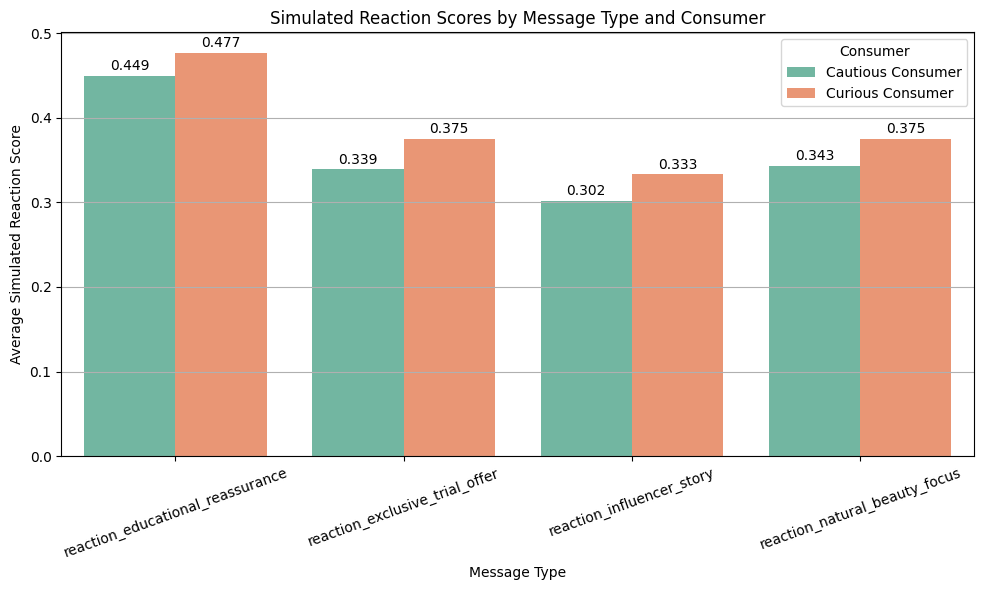

In [8]:
persona_map = {0: "Cautious Consumer", 1: "Curious Consumer"}
df['persona'] = df['cluster'].map(persona_map)

messages = {
    "educational_reassurance": "Understand the process, reduce worry",
    "exclusive_trial_offer": "Try it safely before you commit",
    "influencer_story": "See how others benefit from PMU",
    "natural_beauty_focus": "Enhance subtly, stay authentic"
}

def simulate_response(row, message_type):
    base = row['pmu_interest_level']
    if message_type == "educational_reassurance":
        return base + 0.2 * (1 - row['risk_tolerance']) + 0.2 * row['information_skepticism']
    elif message_type == "exclusive_trial_offer":
        return base + 0.2 * (1 - row['pain_sensitivity']) + 0.1 * row['novelty_seeking']
    elif message_type == "influencer_story":
        return base + 0.2 * row['influencer_trust']
    elif message_type == "natural_beauty_focus":
        return base + 0.2 * row['natural_look_preference']
    return base

for key in messages.keys():
    df[f"reaction_{key}"] = df.apply(lambda row: simulate_response(row, key), axis=1)

reaction_cols = [col for col in df.columns if col.startswith("reaction_")]
persona_reactions = df.groupby("persona")[reaction_cols].mean().round(3)

print("\nSimulated Messaging Reactions by Consumer:\n")
print(persona_reactions)
persona_reactions.to_csv("data/simulated_messaging_by_persona.csv")

reactions_melted = persona_reactions.T.reset_index()
reactions_melted = reactions_melted.rename(columns={"index": "message_type"})
reactions_melted = reactions_melted.melt(id_vars="message_type", var_name="persona", value_name="reaction_score")

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=reactions_melted, x="message_type", y="reaction_score", hue="persona", palette="Set2")
for bars in ax.containers:
    ax.bar_label(bars, fmt="%.3f", padding=2)
plt.title("Simulated Reaction Scores by Message Type and Consumer")
plt.xlabel("Message Type")
plt.ylabel("Average Simulated Reaction Score")
plt.xticks(rotation=20)
plt.grid(True, axis='y')
plt.legend(title="Consumer")
plt.tight_layout()
plt.show()

## Simulate Interventions
* Explore how changing certain features affect each cluster
* Reassign clusters using original KMeans model

Cluster Composition Changes After Interventions:
         original  influencer_campaign  pain_relief  price_cut  \
cluster                                                          
0           0.793                0.529        0.786      0.476   
1           0.207                0.471        0.214      0.524   

         cultural_shift  education_push  
cluster                                  
0                 0.494           0.419  
1                 0.506           0.581  


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_4154/3241094691.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=intervention_names, y=values.values, palette="coolwarm")


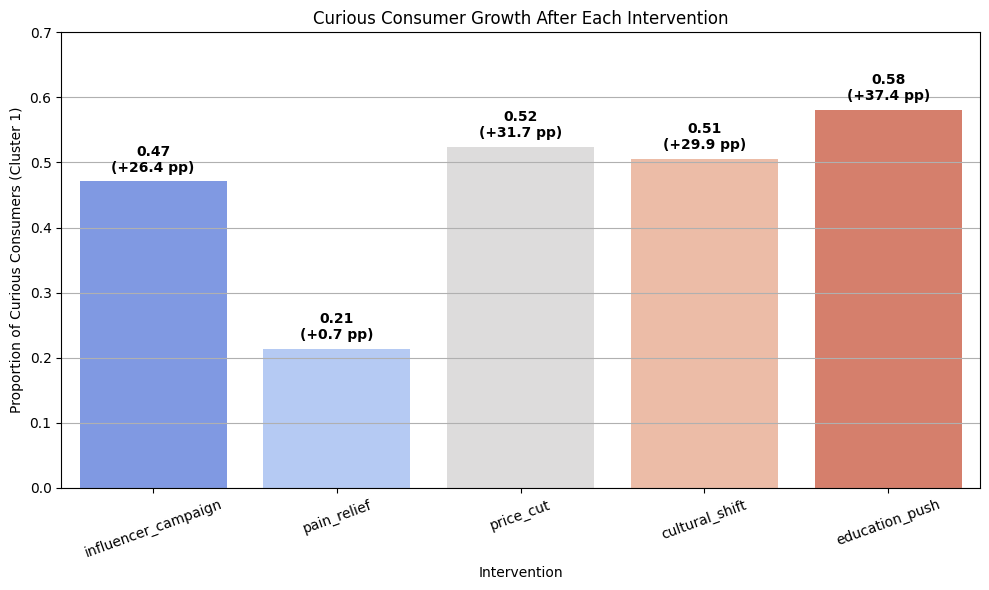

In [14]:
X_preprocessed = preprocessor.fit_transform(df)
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto').fit(X_preprocessed)

scenarios = {
    "influencer_campaign": lambda d: d.assign(influencer_trust=(d['influencer_trust'] + 0.3).clip(0, 1)),
    "pain_relief": lambda d: d.assign(pain_sensitivity=(d['pain_sensitivity'] - 0.3).clip(0, 1)),
    "price_cut": lambda d: d.assign(income_level=(d['income'] - 1).clip(lower=0)),
    "cultural_shift": lambda d: d.assign(cultural_conservatism=(d['cultural_conservatism'] - 0.3).clip(0, 1)),
    "education_push": lambda d: d.assign(information_skepticism=(d['information_skepticism'] - 0.3).clip(0, 1)),
}

results = {"original": df['cluster'].value_counts(normalize=True).rename("original")}

for name, func in scenarios.items():
    modified_df = func(df.copy())
    X_mod = preprocessor.transform(modified_df)
    modified_df["new_cluster"] = kmeans.predict(X_mod)
    results[name] = modified_df["new_cluster"].value_counts(normalize=True).rename(name)

cluster_shifts = pd.concat(results.values(), axis=1).fillna(0).round(3)
cluster_shifts.index.name = "cluster"

print("Cluster Composition Changes After Interventions:")
print(cluster_shifts)

baseline = cluster_shifts.loc[1, "original"]
intervention_names = cluster_shifts.columns[1:]  
values = cluster_shifts.loc[1, intervention_names]
point_increase = ((values - baseline) * 100).round(1)  

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=intervention_names, y=values.values, palette="coolwarm")
for i, (val, diff) in enumerate(zip(values, point_increase)):
    label = f"{val:.2f}\n(+{diff} pp)"
    ax.text(i, val + 0.01, label, ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.ylim(0, 0.7)
plt.ylabel("Proportion of Curious Consumers (Cluster 1)")
plt.title("Curious Consumer Growth After Each Intervention")
plt.xlabel("Intervention")
plt.xticks(rotation=20)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Cluster Composition Under Multi-Intervention Combos:

         original  influencer_education  price_culture  pain_education  \
cluster                                                                  
0           0.793                 0.482          0.494           0.717   
1           0.207                 0.518          0.506           0.283   

         triple_combo  
cluster                
0                0.45  
1                0.55  


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_4154/4091361376.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=combo_names, y=values.values, palette="viridis")


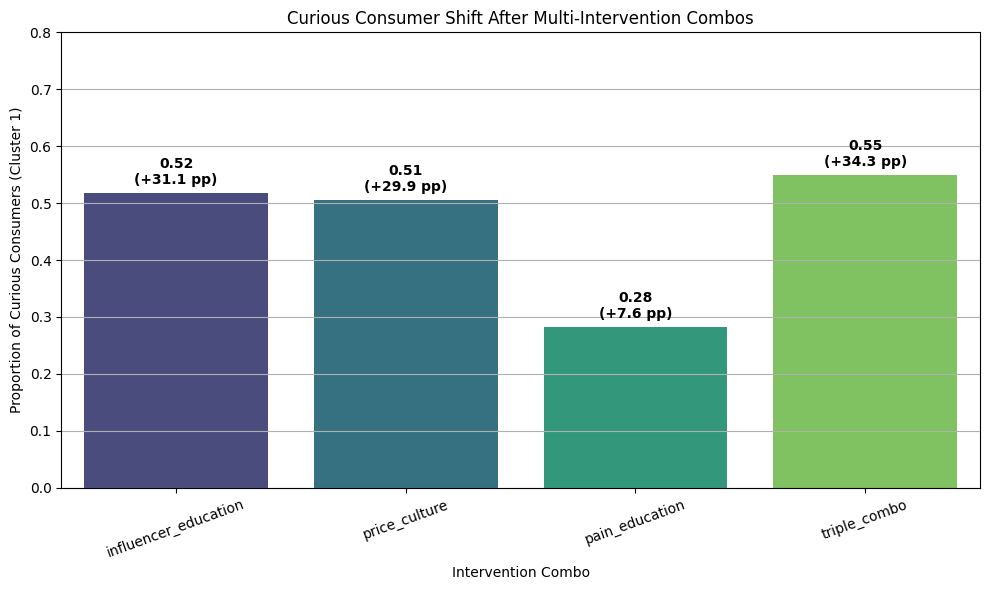

In [15]:
df = pd.read_csv("data/synthetic_pmu_with_clusters.csv")

def influencer_campaign(d): return d.assign(influencer_trust=(d['influencer_trust'] + 0.3).clip(0, 1))
def pain_relief(d): return d.assign(pain_sensitivity=(d['pain_sensitivity'] - 0.3).clip(0, 1))
def price_cut(d): return d.assign(income=(d['income'] - 1).clip(lower=0))
def cultural_shift(d): return d.assign(cultural_conservatism=(d['cultural_conservatism'] - 0.3).clip(0, 1))
def education_push(d): return d.assign(information_skepticism=(d['information_skepticism'] - 0.3).clip(0, 1))

# Combos to test
combo_scenarios = {
    "influencer_education": lambda d: education_push(influencer_campaign(d)),
    "price_culture": lambda d: cultural_shift(price_cut(d)),
    "pain_education": lambda d: education_push(pain_relief(d)),
    "triple_combo": lambda d: education_push(price_cut(cultural_shift(d))),
}
results = {"original": df['cluster'].value_counts(normalize=True).rename("original")}

for name, func in combo_scenarios.items():
    modified_df = func(df.copy())
    X_mod = preprocessor.transform(modified_df)
    modified_df["new_cluster"] = kmeans.predict(X_mod)
    results[name] = modified_df["new_cluster"].value_counts(normalize=True).rename(name)

multi_combo_shift = pd.concat(results.values(), axis=1).fillna(0).round(3)
multi_combo_shift.index.name = "cluster"

print("Cluster Composition Under Multi-Intervention Combos:\n")
print(multi_combo_shift)

baseline = multi_combo_shift.loc[1, "original"]
combo_names = multi_combo_shift.columns[1:]  

values = multi_combo_shift.loc[1, combo_names]
point_increase = ((values - baseline) * 100).round(1)  


plt.figure(figsize=(10, 6))
ax = sns.barplot(x=combo_names, y=values.values, palette="viridis")
for i, (val, diff) in enumerate(zip(values, point_increase)):
    label = f"{val:.2f}\n(+{diff} pp)"
    ax.text(i, val + 0.01, label, ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.ylim(0, 0.8)
plt.ylabel("Proportion of Curious Consumers (Cluster 1)")
plt.title("Curious Consumer Shift After Multi-Intervention Combos")
plt.xlabel("Intervention Combo")
plt.xticks(rotation=20)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

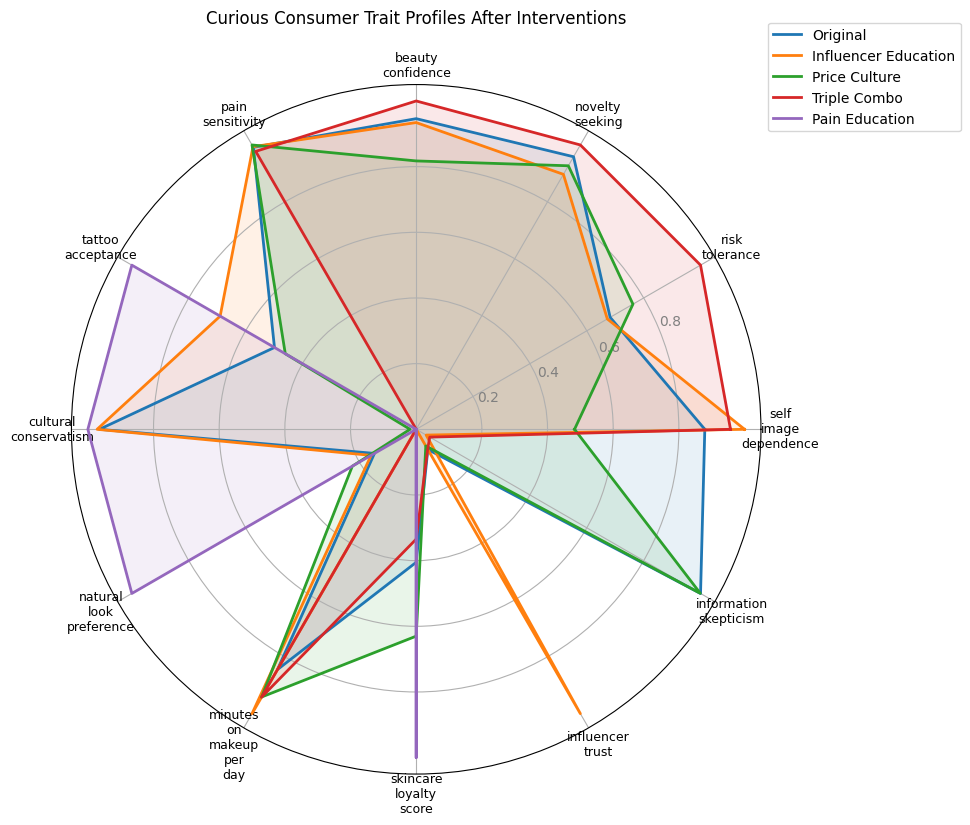

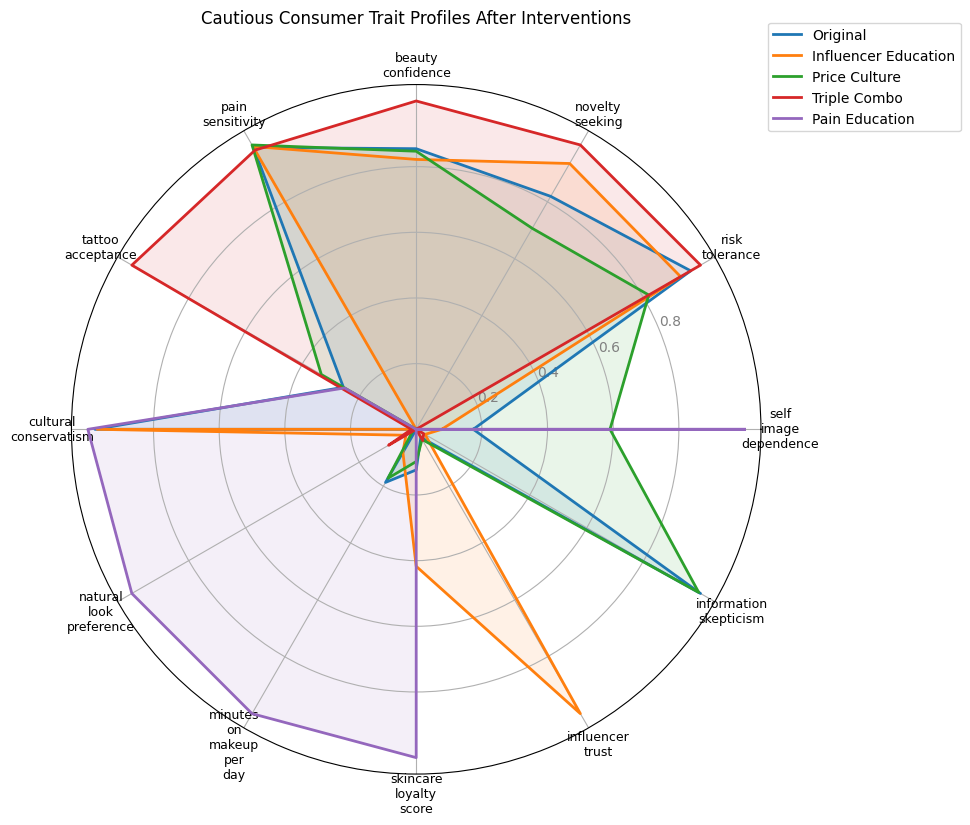

In [21]:
trait_cols = [
    'self_image_dependence', 'risk_tolerance', 'novelty_seeking',
    'beauty_confidence', 'pain_sensitivity', 'tattoo_acceptance',
    'cultural_conservatism', 'natural_look_preference',
    'minutes_on_makeup_per_day', 'skincare_loyalty_score',
    'influencer_trust', 'information_skepticism'
]

cautious_profiles = {}
curious_profiles = {}

for name, data in scenarios.items():
    X_mod = preprocessor.transform(data)
    data["new_cluster"] = kmeans.predict(X_mod)
    cautious_profiles[name] = data[data["new_cluster"] == 0][trait_cols].mean()
    curious_profiles[name] = data[data["new_cluster"] == 1][trait_cols].mean()

df_cautious = pd.DataFrame(cautious_profiles).T
df_curious = pd.DataFrame(curious_profiles).T

scaler = MinMaxScaler()
df_cautious_norm = pd.DataFrame(scaler.fit_transform(df_cautious), columns=trait_cols, index=df_cautious.index)
df_curious_norm = pd.DataFrame(scaler.fit_transform(df_curious), columns=trait_cols, index=df_curious.index)

def plot_radar(df, title):
    categories = trait_cols
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)] + [0]

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)

    for name in df.index:
        values = df.loc[name].tolist()
        values += values[:1]
        ax.plot(angles, values, label=name.replace("_", " ").title(), linewidth=2)
        ax.fill(angles, values, alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([label.replace("_", "\n") for label in categories], fontsize=9)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8"], color="gray")
    ax.set_title(title, pad=20)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()
plot_radar(df_curious_norm, "Curious Consumer Trait Profiles After Interventions")
plot_radar(df_cautious_norm, "Cautious Consumer Trait Profiles After Interventions")

Cautious Consumers
* This group responds more emotionally, pain and safety are major motivators
* Pain sensitivity is substantially lower in pain education, which shows the effectiveness of emotional reassurance
* Information skepticism drops significantly in influencer education and triple combo, showing that education has a large impact in teaching them the benefits and safety of the cosmetic practice

Curious Consumers
* The best intervention for this group is the triple combo which changes their belief and behavior traits
* Their skincare loyalty score experiences a big jump in pain education, showing that they're likely to form brand affinity when the fear is reduced
* Influencer trust is the most effective for social proof

In [22]:
curious_pct_change = ((df_curious - df_curious.loc["original"]) / df_curious.loc["original"] * 100).round(1)
curious_pct_change = curious_pct_change.drop("original")  

cautious_pct_change = ((df_cautious - df_cautious.loc["original"]) / df_cautious.loc["original"] * 100).round(1)
cautious_pct_change = cautious_pct_change.drop("original")

def format_change_table(raw_df, pct_df):
    formatted = raw_df.drop("original").copy()
    for col in raw_df.columns:
        formatted[col] = [
            f"{raw_df.loc[i, col]:.2f} ({pct_df.loc[i, col]:+.1f}%)"
            for i in raw_df.index if i != "original"
        ]
    return formatted

curious_table = format_change_table(df_curious, curious_pct_change)
cautious_table = format_change_table(df_cautious, cautious_pct_change)

print("\nCurious Consumer – Trait Means + % Change from Original:\n")
print(curious_table)

print("\nCautious Consumer – Trait Means + % Change from Original:\n")
print(cautious_table)


Curious Consumer – Trait Means + % Change from Original:

                     self_image_dependence risk_tolerance novelty_seeking  \
influencer_education          0.52 (+0.1%)   0.23 (-0.1%)    0.55 (-0.6%)   
price_culture                 0.52 (-0.4%)   0.23 (+0.5%)    0.55 (-0.3%)   
triple_combo                  0.52 (+0.1%)   0.23 (+2.0%)    0.56 (+0.4%)   
pain_education                0.51 (-0.8%)   0.22 (-4.3%)    0.50 (-9.2%)   

                     beauty_confidence pain_sensitivity tattoo_acceptance  \
influencer_education      0.42 (-0.1%)     0.78 (+0.1%)      0.41 (+0.2%)   
price_culture             0.41 (-1.5%)     0.78 (+0.3%)      0.41 (-0.0%)   
triple_combo              0.42 (+0.6%)     0.78 (-0.5%)      0.41 (-0.6%)   
pain_education           0.38 (-10.8%)    0.51 (-35.2%)      0.41 (+0.6%)   

                     cultural_conservatism natural_look_preference  \
influencer_education          0.42 (+0.5%)            0.62 (+0.0%)   
price_culture                

In [26]:
def highlight_extremes(pct_df, persona_label):
    print(f"\nTop Trait Shifts for {persona_label} Consumers\n")
    for scenario in pct_df.index:
        row = pct_df.loc[scenario]
        top_increase = row.sort_values(ascending=False).head(3)
        top_decrease = row.sort_values().head(3)

        print(f"{scenario.replace('_', ' ').title()} – Top Increases:")
        for trait, change in top_increase.items():
            print(f"   + {trait.replace('_', ' ').title()}: {change:+.1f}%")

        print(f"{scenario.replace('_', ' ').title()} – Top Decreases:")
        for trait, change in top_decrease.items():
            print(f"   - {trait.replace('_', ' ').title()}: {change:+.1f}%")
        
        print("-" * 50)

highlight_extremes(curious_pct_change, "Curious")
highlight_extremes(cautious_pct_change, "Cautious")


Top Trait Shifts for Curious Consumers

Influencer Education – Top Increases:
   + Influencer Trust: +80.7%
   + Cultural Conservatism: +0.5%
   + Tattoo Acceptance: +0.2%
Influencer Education – Top Decreases:
   - Information Skepticism: -67.0%
   - Novelty Seeking: -0.6%
   - Skincare Loyalty Score: -0.4%
--------------------------------------------------
Price Culture – Top Increases:
   + Risk Tolerance: +0.5%
   + Pain Sensitivity: +0.3%
   + Natural Look Preference: +0.3%
Price Culture – Top Decreases:
   - Cultural Conservatism: -62.7%
   - Beauty Confidence: -1.5%
   - Influencer Trust: -1.1%
--------------------------------------------------
Triple Combo – Top Increases:
   + Risk Tolerance: +2.0%
   + Beauty Confidence: +0.6%
   + Novelty Seeking: +0.4%
Triple Combo – Top Decreases:
   - Information Skepticism: -66.1%
   - Cultural Conservatism: -64.0%
   - Tattoo Acceptance: -0.6%
--------------------------------------------------
Pain Education – Top Increases:
   + Natura

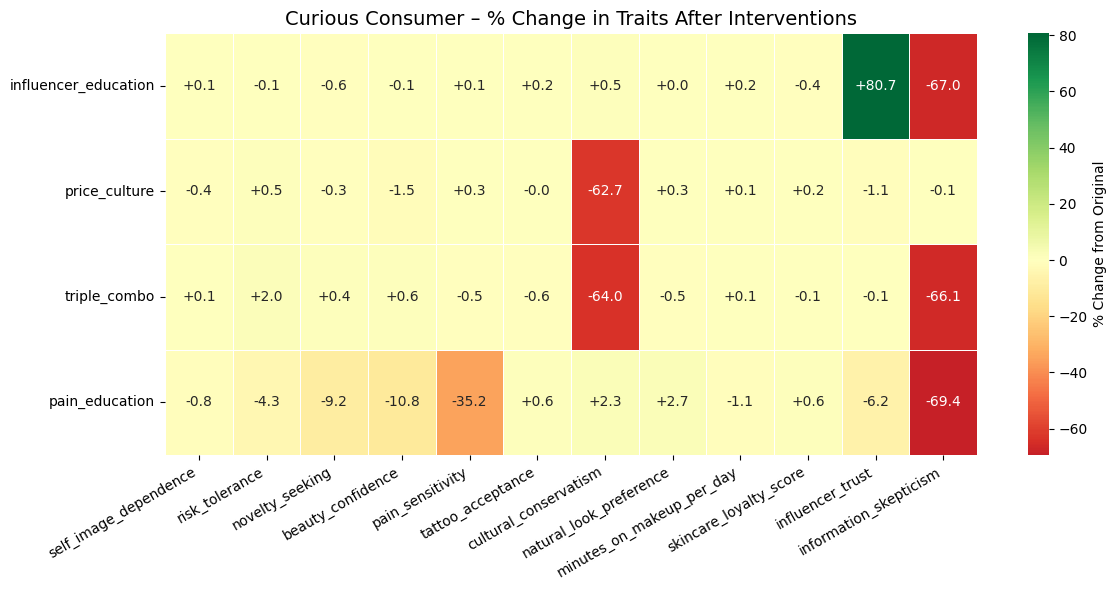

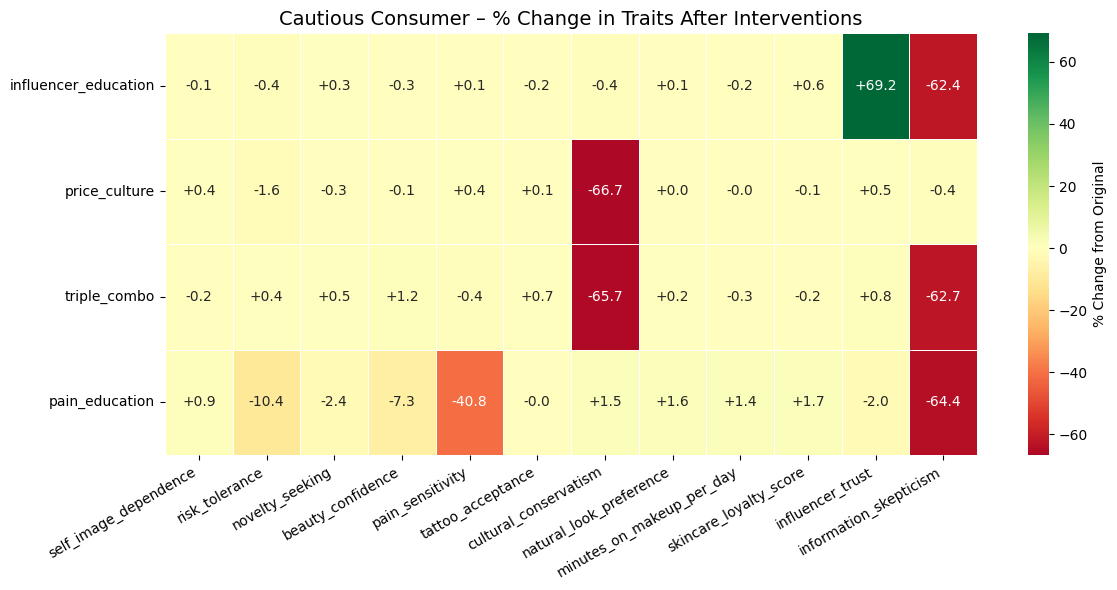

In [25]:
# Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    curious_pct_change,
    annot=True,
    fmt="+.1f",
    cmap="RdYlGn",
    center=0,
    linewidths=0.5,
    cbar_kws={'label': '% Change from Original'}
)
plt.title("Curious Consumer – % Change in Traits After Interventions", fontsize=14)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(
    cautious_pct_change,
    annot=True,
    fmt="+.1f",
    cmap="RdYlGn",
    center=0,
    linewidths=0.5,
    cbar_kws={'label': '% Change from Original'}
)
plt.title("Cautious Consumer – % Change in Traits After Interventions", fontsize=14)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

Key Takeaways
Curious Consumer Cluster
* Across all features, influencer_trust experienced the most shift increase
    * Best intervention is a combination of influencer + education shift
    * Best way to convert interest into readiness
* Cultural conservatism experienced the most decrease
    * Best intervention is triple combination or price + culture intervention
    * Best way to remove cultural resistance

Cautious Consumer Cluster
* Across all features, influencer_trust experienced the most shift increase
    * Best intervention is a combination of influencer + education
    * Event skeptical groups respond positively to targeted narratives
* Cultural conservatism experienced the most decrease
    * Best wintervention is triple combination or price + culture intervention
    * Ideological changes and confidence boosts are possible

## Consumer Profiles
Cluster 0: Cautious Consumer
* This is the group of consumers who are driven by self-care and self-image. Their main barrier towards new cosmetic practices is the fear of regret, safety concerns, and cultural stigma. This group requires more time to convert as they need more reassurance, validation, and cultural acceptance towards PMU. To target this group, include evidence-based benefits in the marketing message, gently onboard them, and create low-commitment entry points such as introducing brow tinting before microblading.
* Pre-Intervention Personality Traits
    * Low risk tolerance
    * High pain sensitivity
    * Moderate self-image dependence
    * Conservative cultural views
    * Low influencer trust, high information skepticism
* Best Interventions
    * Influencer Education: Reduces skepticism, raises trust (+69%)
    * Price + Cultural Shift: Dismantles cultural barriers (↓66% conservatism)
    * Pain + Education: Lowers fear (↓41% pain sensitivity), builds loyalty

Cluster 1: Curious Consumer
* This is the group of consumers who are curious and digitally literate, but may be hesitant due to confidence, skepticism, and cultural stigma twoards PMU. They tend to fall into the category of early adopters, but with some level of hesitation. It is best to incorporate marketing messaging and strategies that resonate with their desire to modernize, optimize beauty reoutines, and align with peer norms.
* Pre-Intervention Personality Traits
    * Moderate risk tolerance
    * Medium-high novelty seeking
    * Lower influencer trust, but open-minded
    * Low tattoo acceptance, image-dependent
* Best Interventions
    * Influencer Education: Builds social confidence (+80% trust, ↓67% skepticism)
    * Triple Combo: Dismantles ideology & hesitation (↓66% conservatism)
    * Pain + Education: Boosts aesthetic preference and lowers resistance